# Control de pH en plantas hidropónicas

**Idea:** proponer un controlador continuo para regular el $p_H$ de un sistema de riego hidropónico.

**Hipótesis previas:** asumimos que el sistema sin controlador tiene una respuesta natural de primer orden, del orden de días de tiempo de establecimiento. Si el sistema se deja sin control, el $p_H$ converge a 7 desde la condición inicial.

A los efectos del análisis, el $p_H=7$ corresponde a un valor de $0$, es decir, se mide el pH como desvíos del neutro.

## Modelo sistema sin control:

* Entrada: $u_1(t)=x_0\delta(t)$ (solo la condición inicial, $x_0 = p_H(0)-7$).

* Salida: $y(t) = p_H-7$

**Planta:** 

$$u_1\mapsto y:\quad H_1(s) = \frac{1}{s+1/T_0}$$

siendo $T_0 = 17280 $ (1 día = 86400s = 5 constantes de tiempo).

In [1]:
using ControlSystems, Plots

T0 = 86400.0/5

sys1 = tf([1],[1,1/T0])

TransferFunction{Continuous, ControlSystems.SisoRational{Float64}}
            1.0
---------------------------
1.0s + 5.787037037037037e-5

Continuous-time transfer function model

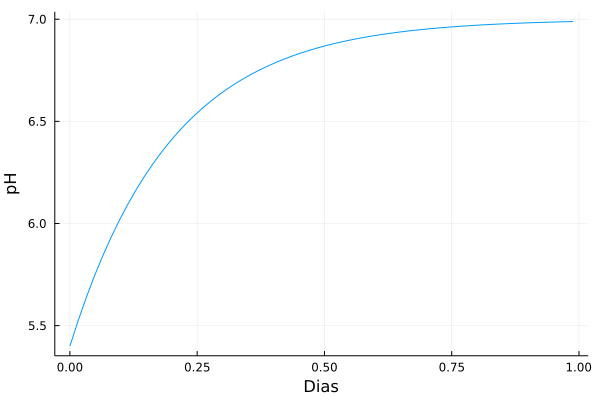

In [2]:
pH0 = 5.4 #valor de referencia que hablamos
x0 = pH0-7

#calculo la respuesta al impulso unitario
y,t,x = impulse(sys1, 5*T0)

#ajusto la condición inicial x0
y=x0*y

plot(t/86400,y[:].+7, xlabel="Dias", ylabel="pH", legend=:none)

## Modelo del actuador:

El actuador consiste en colocar un cierto *caudal* de solución ácida para mover el equilibrio natural.

Por experimentación, se sabe que colocar $10 ml$ de solución baja el $p_H$ en una unidad al cabo de media hora. Podemos suponer que en dicho experimento:

 * La respuesta natural del sistema (del orden de días) permaneció constante.
 * $10ml$ de solución actúan como un "impulso" de caudal.
 
Proponemos entonces el siguiente modelo:

* Entrada: $u_2(t)=$ caudal de solución. En el caso de prueba es $10\delta(t)$.
* Salida:  $y(t) = p_H-7$.

**Planta:** 

$$u_2\mapsto y:\quad H_2(s) = \frac{G}{s(s+1/T_1)}$$

Corresponde a un integrador (convierte caudal en cantidad de solución) y luego una respuesta natural de duración $T_1$.

Tomamos: $T_1 = 360s$ (1/2 hora de tiempo de establecimiento).

Para adecuar $G$ observemos que una entrada $10\delta(t)$ produce un cambio de $-1$ unidad. Asumiendo linealidad, un impulso unitario debería producir una respuesta igual a $-0.1$ unidades de $p_H$.  

La respuesta en régimen de $H_2$ al impulso es:

$$\lim_{s\to 0} sH_2(s) = \lim_{s\to 0} \frac{G}{s+1/T_1} = GT_1 = -0.1$$

de donde $G=-0.1/T_1 = -1/3600$.

In [3]:
T1=360
G=-.1/T1
sys2 = tf([1.0], [1.0,0])*tf([G],[1.0,1/T1])

TransferFunction{Continuous, ControlSystems.SisoRational{Float64}}
    -0.0002777777777777778
------------------------------
1.0s^2 + 0.002777777777777778s

Continuous-time transfer function model

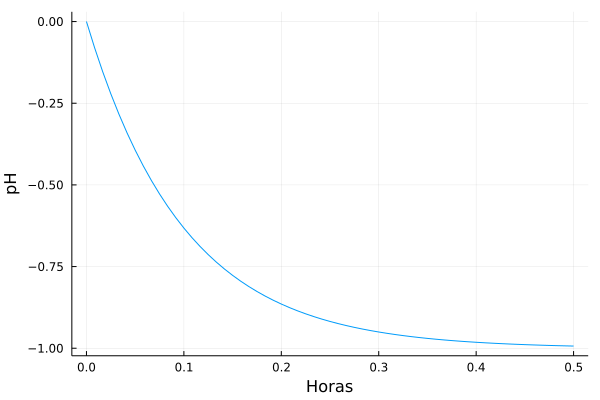

In [4]:
y,t,x = impulse(sys2, 5*T1)
y=10*y #para adecuar inyectar 10ml
plot(t/3600,y[:], xlabel="Horas", ylabel="pH", legend=:none)

## Propuesta de control realimentado

Se desea mantener el $p_H$ en un valor de referencia negativo (ácido). Para ello, se propone realimentar el valor medido de $p_H$ comparado con una referencia a la entrada de caudal. El esquema completo es:

![Hola](sistema_realimentado.png)

## Análisis

Se debe analizar la estabilidad del lazo realimentado a las dos entradas ($u_1$ y $x_{ref}$), y ver si el estado estacionario corresponde a $y=x_{ref}$ cuando esta última es constante.

Trabajando en Laplace, se tiene que:

$$Y(s) = H_1(s)U_1(s) + H_2(s)U_2(s).$$

Por el feedback:

$$U_2(s) = k(X_{ref}(s)-Y(s)),$$

de donde sustituyendo queda:

$$Y(s) = H_1(s)U_1(s) + H_2(s)k(X_{ref}(s) - Y(s)).$$

Por lo tanto:

$$Y(s) = \frac{H_1(s)}{1+kH_2(s)} U_1(s) + \frac{k H_2(s)}{1+kH_2(s)}X_{ref}(s).$$

Cada término corresponde a la transferencia entrada salida de cada una de las entradas en el sistema realimentado.

## Estabilidad

Debemos ver si el sistema lazo cerrado es estable en cada entrada. Para ello analicemos las transferencias anteriores sustituyendo los modelos.

### $u_1\mapsto y$

$$\frac{H_1(s)}{1+kH_2(s)} = \frac{\frac{1}{s+1/T_0}}{1+k\frac{G}{s(s+1/T_1)}} = \frac{s\left(s+\frac{1}{T_1}\right)}{\left(s+\frac{1}{T_0}\right)\left(s^2+\frac{1}{T_1}s+kG\right)}$$

### $x_{ref}\mapsto y$

$$\frac{kH_2(s)}{1+kH_2(s)} = \frac{k\frac{G}{s(s+1/T_1)}}{1+k\frac{G}{s(s+1/T_1)}} = \frac{kG}{\left(s^2+\frac{1}{T_1}s+kG\right)} $$

La primera tiene un polo en $1/T_0$ y luego dos polos de suma negativa y producto $kG$. La segunda solo tiene estos mismos dos polos. Por lo tanto, ambas transferencias son estables siempre que el producto $kG$ sea positivo.

**Observación:** Notar que $G<0$, ya que la entrada $u_1$ (caudal positivo de solución) hace bajar el $p_H$. La señal de error es *negativa* cuando el $p_H$ está por debajo de la referencia. Por lo tanto, es natural utilizar también $k<0$, ya que si el error es positivo (más básico), debemos inyectar solución ($u_1>0$). Es por ello que el producto $kG$ queda positivo.



## Estado estacionario

Si el sistema es estable, en estado estacionario $u_2$ debe ser $0$ ya que la entrada a $H_2$ es un integrador. Por lo tanto, $err=0$ y el $p_H$ sigue a la referencia. La ganancia $k$ puede usarse para controlar el tiempo de estabilización. También se puede observar del siguiente modo:

$$err = x_{ref} - y$$

de donde en Laplace:

$$Err(s) = X_{ref}(s)  - Y(s) = X_{ref}(s) - \frac{H_1(s)}{1+kH_2(s)} U_1(s) - \frac{k H_2(s)}{1+kH_2(s)}X_{ref}(s) = - \frac{H_1(s)}{1+kH_2(s)} U_1(s) + \frac{1}{1+kH_2(s)}X_{ref}(s)$$

De donde la respuesta del sistema a un escalón en $x_{ref}$ se calcula como:

$$\lim_{s\to 0} \frac{1}{1+kH_2(s)} =lim_{s\to 0} \frac{1}{1+k\frac{G}{s(s+1/T_1)}} \lim_{s\to 0} \frac{s(s+1/T_1)}{s^2+\frac{1}{T_1}s+kG} = 0.$$

## Elección de $k$

En el procedimiento anterior, el sistema estabiliza para cualquier $k$ y aumentar el valor de $k$ acelera la respuesta y por tanto la convergencia a la referencia.

Sin embargo, en el sistema real, solo podemos tener control $u_2$ positivo, correspondiente a agregar ácido. Si la señal de error se vuelve positiva por sobretiro (bajamos más el valor ácido que la referencia), el sistema queda en lazo abierto ya que $u_2$ no puede ser negativo. Si bien vuelve al equilibrio debido a la respuesta natural (que lleva el sistema hacia arriba de cualquier referencia negativa), la velocidad de convergencia pasará a estar dominada por el polo $1/T_0$ (lento).

Es por ello que un criterio para $kG$ es que el sistema de segundo orden realimentado quede con amortiguamiento crítico, esto es que:

$$s^2 + \frac{1}{T_1}s + kG$$

tenga raíz doble, o bien:

$$\frac{1}{T_1^2} - 4kG = 0,$$

lo que determina el valor de $k$. Por ejemplo para los valores anteriores:


In [5]:
k = 1/(T1^2*4*G)

-0.006944444444444444

## Simulación

In [6]:
#construyo el sistema realimentado usando las transferencias calculadas antes

#sistema lazo cerrado u_1 -> y
G1 = tf([1,1/T1,0],[1,1/T1,k*G])

TransferFunction{Continuous, ControlSystems.SisoRational{Float64}}
            1.0s^2 + 0.002777777777777778s
------------------------------------------------------
1.0s^2 + 0.002777777777777778s + 1.9290123456790124e-6

Continuous-time transfer function model

In [7]:
#sistema lazo cerrado x_ref -> y
G2 = tf([k*G],[1,1/T1,k*G])

TransferFunction{Continuous, ControlSystems.SisoRational{Float64}}
                1.9290123456790124e-6
------------------------------------------------------
1.0s^2 + 0.002777777777777778s + 1.9290123456790124e-6

Continuous-time transfer function model

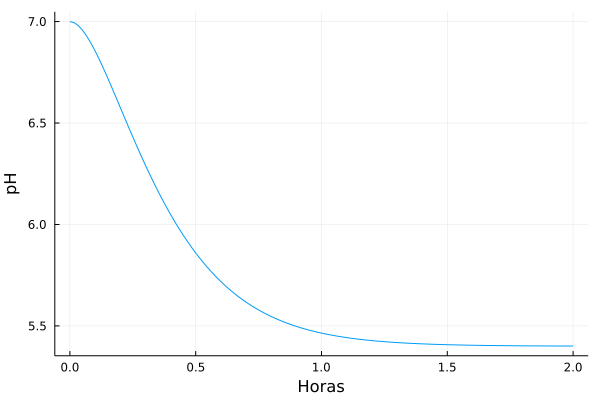

In [8]:
#simulo un escalón en xref con ph inicial 7 (condición inicial nula en u_1)
y,t,x = step(G2, 7200)

referencia = 5.4
xref = referencia-7

y = xref*y[:].+7

plot(t/3600,y, xlabel="Horas", ylabel="pH", legend=:none)

El sistema recupera la referencia en algo más de 1 hora.

### Ejemplo subamortiguado

Tomemos $k$ 10 veces mayor. La respuesta se vuelve más ácida de lo requerido y el control no es plausible. En la práctica, habrá que esperar a que supere el valor de referencia para retomar el control.

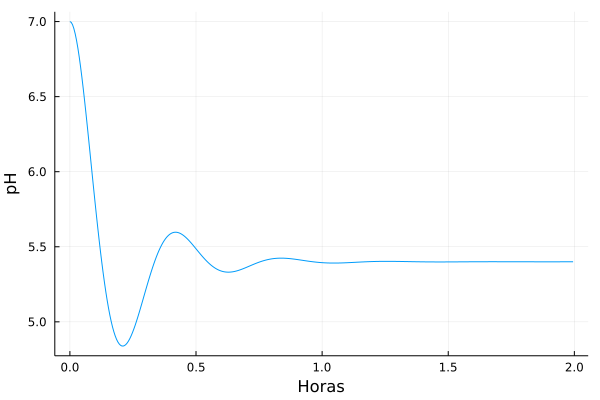

In [9]:
k2=10*k
G22 = tf([k2*G],[1,1/T1,k2*G])

y2,t2,x2 = step(G22, 7200)

y2 = xref*y2[:].+7

plot(t2/3600,y2, xlabel="Horas", ylabel="pH", legend=:none)

## Esfuerzo de control

A modo de validación, calculemos el esfuerzo requerido para llevar el $pH$ de $7$ a la referencia como el total de solución vertida.

Para ello, observemos que $u_2(t)$ es el caudal, por lo que la integral de $u_2(t)$ es el acumulado de solución.

Se tiene que:

$$U_2(s) = k(X_{ref}(s)-Y(s)) = k\left[X_{ref}(s) - \frac{H_1(s)}{1+kH_2(s)} U_1(s) - \frac{k H_2(s)}{1+kH_2(s)}X_{ref}(s)\right].$$

De donde:
$$U_2(s) = - \frac{kH_1(s)}{1+kH_2(s)} U_1(s) + \frac{k}{1+kH_2(s)}X_{ref}(s).$$

Si $u_1$ es 0, y la condición inicial es nula ($p_H=7$) entonces el caudal total se calcula como:

$$C(s) = \frac{1}{s} \frac{k}{1+kH_2(s)}X_{ref}(s).$$

Para un escalón en $x_{ref}$ la respuesta es, en Laplace:

$$\frac{x_{ref}}{s^2} \frac{k}{1+kH_2(s)}.$$

Calculemos ahora el valor final:

$$\lim_{s\to 0} s \frac{x_{ref}}{s^2} \frac{k}{1+kH_2(s)} = \lim_{s\to 0} \frac{k x_{ref}}{s(1+k\frac{G}{s(s+1/T_1)})} = \lim_{s\to 0} \frac{k x_{ref} (s+1/T_1)}{s^2+\frac{1}{T_1}s+kG} = \frac{x_{ref}}{GT_1} $$

**Observación:** el esfuerzo requerido no depende de la velocidad del control ni del polo, ya que $G=.1/T_1$

Para los valores anteriores:

* x_ref = -1.6
* G=-.1/T_1

El esfuerzo son $16ml$. Esto lo sabíamos antes de empezar por la calibración del sistema.

In [10]:
total_solucion = xref/(G*T1)

15.999999999999996